<a href="https://colab.research.google.com/github/Davidportlouis/flower_recognition/blob/master/flower_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim
from torchvision import datasets,transforms
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from helper import plot_batch,train,test,predict,predict_image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content/gdrive/My Drive/kaggle"
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip \*.zip && rm *.zip
!mkdir test
!mv ./flowers/flowers/* ./test/
!rm ./flowers/flowers

In [ ]:
train_transform = transforms.Compose([
  transforms.RandomResizedCrop(255),
  transforms.RandomRotation(45),
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485,0.456,0.406],
                       std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
  transforms.RandomResizedCrop(255),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485,0.456,0.406],
                       std=[0.229,0.224,0.225])
])

train_data = datasets.ImageFolder("train",transform=train_transform)
test_data = datasets.ImageFolder("test",transform=test_transform)

train_len = len(train_data)
idx = list(range(train_len))
np.random.shuffle(idx)
split = int(np.floor(0.2 * train_len))
valid_idx,train_idx = idx[:split],idx[split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data,batch_size=20,sampler=train_sampler)
valid_loader = DataLoader(train_data,batch_size=20,sampler=valid_sampler)
test_loader = DataLoader(test_data,batch_size=20,shuffle=True)
classes = train_data.classes

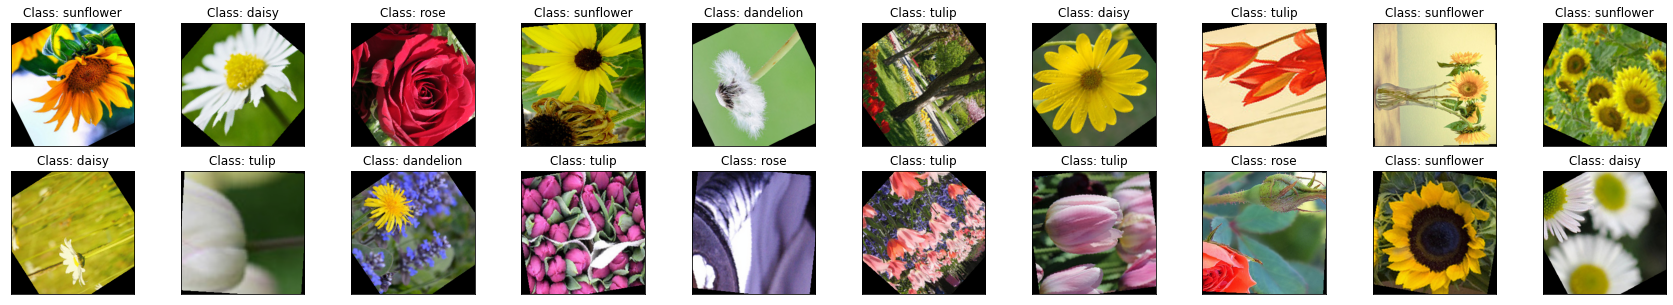

In [ ]:
train_images,train_labels = next(iter(train_loader))
plot_batch(train_images,classes,train_labels,normalize=True)

In [ ]:
class FloraNet(nn.Module):
  def __init__(self,conv_dim=32):
    super(FloraNet,self).__init__()
    self.conv_1 = nn.Conv2d(3,conv_dim,3,1,1)
    self.conv_2 = nn.Conv2d(conv_dim,conv_dim*2,3,1,1)
    # self.conv_3 = nn.Conv2d(conv_dim*2,conv_dim*4,3,1,1)
    self.maxpool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.3)
    self.bnorm_1 = nn.BatchNorm2d(conv_dim)
    self.bnorm_2 = nn.BatchNorm2d(conv_dim*2)
    # self.bnorm_3 = nn.BatchNorm2d(conv_dim*4)
    self.fc1 = nn.Linear(63*63*conv_dim*2,512)
    # self.fc2 = nn.Linear(2048,512)
    self.out = nn.Linear(512,5)
  def forward(self,x):
    x = self.conv_1(x)
    x = F.relu(self.bnorm_1(x))
    x = self.maxpool(x)
    x = self.conv_2(x)
    x = F.relu(self.bnorm_2(x))
    x = self.maxpool(x)
    # x = self.conv_3(x)
    # x = F.relu(self.bnorm_3(x))
    # x = self.maxpool(x)
    x = self.dropout(x)
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    # x = F.relu(self.fc2(x))
    # x = self.dropout(x)
    x = self.out(x)
    return x

model = FloraNet()
model = model.to(device)
print(model)

RuntimeError: ignored

In [ ]:
optimizer = optim.SGD(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loss,valid_loss = train(model,train_loader,valid_loader,optimizer,criterion,5,device)

RuntimeError: ignored